# Recommender Systems 2024/25

### Practice 7 – Graph-based Models

## Graph-based Recommenders

### What is a Graph?

In layman terms, a graph is a set of **interconnected entities**. Each entity is represented by a *node*, while the connections are called *edges*. Thus, mathematically speaking, a graph $G \in \mathbb{R}^{n\times n}$ can be represented as two sets, $N$ (nodes) and $E$ (edges).$$G = (N,E) \\ N = \{x_i | i \in [1, |N|]_{\mathbb{N}}\} \\ E = \{\{x_i, x_j\} | x_i,x_j \in N\}$$

### Graph Notation

#### Graph Chart

Nodes are usually represented graphically as circles, with lines (=edges) connecting one another

In [1]:
!pip install plotly

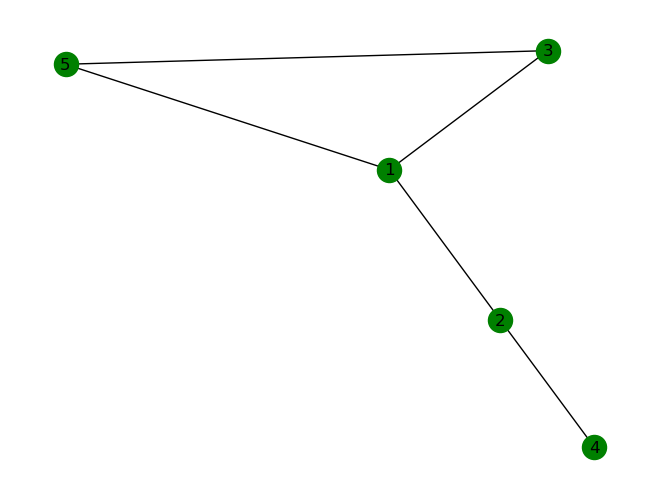

In [2]:
import networkx as nx
import plotly.graph_objects as go

G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(1,3),(1,5),(2,4),(3,5)])

nx.draw(G, with_labels=True, node_color="green")

In [3]:
# Draw a more beautiful, interactive graph

def setup_plotly_graph(G : nx.Graph):
    pos = nx.spring_layout(G)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    node_x, node_y = zip(*pos.values())

    return edge_x, edge_y, node_x, node_y

def draw_plotly(G : nx.Graph):
    edge_x, edge_y, node_x, node_y = setup_plotly_graph(G)

    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                            line=dict(width=1, color='gray'),
                            hoverinfo='none',
                            mode='lines')
    node_trace = go.Scatter(x=node_x, y=node_y,
                            mode='markers+text',
                            marker=dict(size=25, color='blue'),
                            text=list(G.nodes),
                            textposition="top center")

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title="Example Graph",
                                    showlegend=False,
                                    hovermode='closest'))
    
    return fig

fig = draw_plotly(G)
fig.show()


#### Adjacency Lists

For each node in the graph, its adjacency list contains all nodes it is connected to. Pros: easily readable, cons: redundant

In [4]:
for k,v in G.adj.items():
    print("{}: {}".format(k, list(v.keys())))

1: [2, 3, 5]
2: [1, 4]
3: [1, 5]
4: [2]
5: [1, 3]


#### Adjacency Matrices

##### Node-2-Edge

A node-2-edge adjacency matrix $A$ has shape equal to $|N|\times|E|$: each row represents a node within the graph, while each column represents an edge. The element $a_{i,j}$ will be set to 1 (or to edge $j$'s weight) if edge $j$ touches node $i$. Thus, only 2 elements per column (the nodes that are connected by edge $j$) will be greater than zero.

In [5]:
import numpy as np

def node_to_edge_adjacency_matrix(G : nx.Graph):
    # Get the list of nodes and edges
    nodes = list(G.nodes)
    edges = [(x[0] - 1,x[1] - 1) for x in list(G.edges)]

    # Initialize the node-to-edge adjacency matrix
    n = len(nodes)
    m = len(edges)
    matrix = np.zeros((n, m), dtype=np.int32)

    # Populate the matrix
    for edge_index, (u, v) in enumerate(edges):
        matrix[u, edge_index] = 1
        matrix[v, edge_index] = 1

    return matrix

node_to_edge_adjacency_matrix(G)

array([[1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1]], dtype=int32)

##### Node-2-Node

A node-2-node adjacency matrix $B$ has shape equal to $|N|\times |N|$: each row represents a node, as well as each column. Thus, $b_{i,j}$ will be greater than zero if node $i$ is connected to node $j$ by means of edge $(i,j)$.

In [6]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]], dtype=int32)

### For our purposes, the most convenient form of graph representation are n2n adjacency matrices.

### Graphs in Recommendation
- Nodes: users, items
- Edges: interactions

The graph representation of a recommendation scenario is inherently *bipartite*.

> **Bipartite Graph**: a graph $G$ is bipartite if its set of nodes $N$ can be divided into two **disjoint** sets of nodes, $N_1$ and $N_2$, such that for every edge $e$ in $G$, $e$ connects a node belonging to $N_1$ to a node in $N_2$ or vice versa, thus there is no inter-set connections among nodes within $N_1$ nor $N_2$.

In our case, class $N_1$ is defined by the *user nodes*, and class $N_2$ by *item nodes*, since the edges define user-item interactions.

Consequently, the graph's adjacency matrix will **contain the URM**.

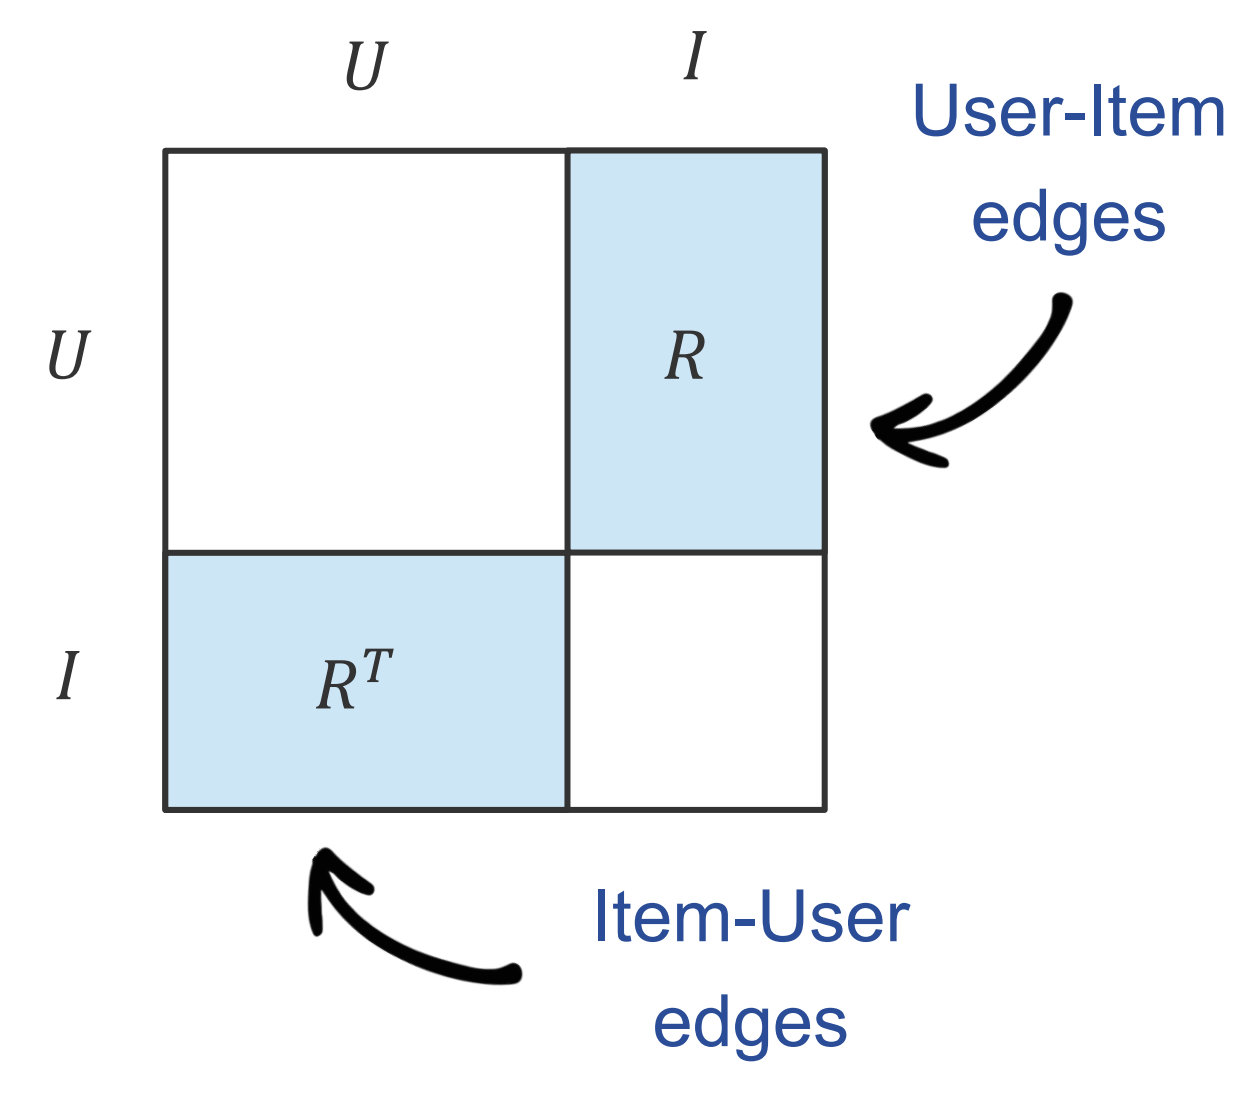

> **Path**: a sequence of $m + 1$ nodes $n_0 \rightarrow n_1 \rightarrow n_2 \rightarrow ... \rightarrow n_m$ such that $\forall i = 1, ..., m, (n_{i-1}, n_{i}) \in E$.

I.e., a *path* is a sequence of connected nodes within a graph. A path will have a starting node $A$ and a destination node $B$. In the context of recommendation, we can think of paths as **collaborative signals**!

### Random Walks

In [7]:
import time
import numpy as np
import scipy.sparse as sps
from sklearn.preprocessing import normalize

#### Illustrative Example
Let's create a graph $G$ with 2 users, 3 items and the following adjacency matrix: $$\begin{bmatrix}0 & 0 & 1 & 0 & 1 \\ 0 & 0 & 1 & 1 & 0 \\ 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0\end{bmatrix}.$$

It corresponds to the following schema:

In [8]:
G = nx.from_dict_of_dicts({
    0 : {2 : {}, 4 : {}},
    1 : {2 : {}, 3 : {}},
    2 : {0 : {}, 1 : {}},
    3 : {1 : {}},
    4 : {0 : {}}
})

draw_plotly(G)

In [9]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int32)

To compute a random walk, we need to compute the node-to-node *transition probability matrix* $P$. Then, we simply select a node and create a starting state $\Pi^{(0)}$, which is nothing more than a one-hot-encoding vector identifying the selected starting node, and we multiply it by $P$, obtaining state $\Pi^{(1)}$. This represents a step in our random walk: if we want to take more steps, we simply take $\Pi^{(n)}$ and multiply it by $P$ again and again, following what is known as a *Markov chain*.

In [10]:
# Transition probability function
def transition(g : np.ndarray, n0 : int, hops : int):
    # initial state
    state = np.zeros(g.shape[1], dtype=np.float32)
    state[n0] = 1

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32)
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

In [11]:
transition(g=a, n0=0, hops=3)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]


array([0.   , 0.   , 0.5  , 0.125, 0.375], dtype=float32)

#### Steady State

If we continue walking for long enough, we will reach a *periodic steady state*: our walk will find an equilibrium, and start jumping from the same subset of users to the same subset of item every time.

In [12]:
transition(g=a, n0=0, hops=50)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]
Hop: 4, state: [0.625 0.375 0.    0.    0.   ]
Hop: 5, state: [0.     0.     0.5    0.1875 0.3125]
Hop: 6, state: [0.5625 0.4375 0.     0.     0.    ]
Hop: 7, state: [0.      0.      0.5     0.21875 0.28125]
Hop: 8, state: [0.53125 0.46875 0.      0.      0.     ]
Hop: 9, state: [0.       0.       0.5      0.234375 0.265625]
Hop: 10, state: [0.515625 0.484375 0.       0.       0.      ]
Hop: 11, state: [0.        0.        0.5       0.2421875 0.2578125]
Hop: 12, state: [0.5078125 0.4921875 0.        0.        0.       ]
Hop: 13, state: [0.         0.         0.5        0.24609375 0.25390625]
Hop: 14, state: [0.50390625 0.49609375 0.         0.         0.        ]
Hop: 15, state: [0.         0.         0.5        0.24804688 0.25195312]
Hop: 16, state: [0.5019531  0.49804688 0.         0.         0.        ]
Hop: 17, state: [0.     

array([0.5, 0.5, 0. , 0. , 0. ], dtype=float32)

### $P^3$, $P^3_\alpha$, $RP^3_\beta$

Loading the dataset and splitting it in the usual way:

In [13]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train_val, URM_test = split_train_in_two_percentage_global_sample(URM_all, 0.8)
URM_train, URM_val = split_train_in_two_percentage_global_sample(URM_train_val, 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_year, Value range: 1.92E+03 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




Our transition function would pretty much still work to build a random-walk based recommender. PROBLEM: this is not an illustrative example. We are dealing with tens of millions of interactions within a matrix that is immensely sparse! Computing it in full as we have done before would kill the program due to memory issues.

In [14]:
def transition_matrix(g : np.ndarray, hops : int):
    # initial state
    state = np.diag(np.ones(g.shape))

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32) # -> this is equivalent to a column-wise l1 normalization
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

To save RAM, we will compute the matrix multiplications in gradual blocks, and store each block in one data structure that will be built up incrementally. Introducing the `Incremental_Similarity_Builder`, a structure built for this exact purpose you can find in the framework:

In [15]:
class Incremental_Similarity_Builder:
    
    def __init__(self, matrix_size_0, matrix_size_1, initial_data_block = 10000000, additional_data_block = 10000000, dtype = np.float32):

        self._matrix_size = [matrix_size_0, matrix_size_1]
        self._initial_data_block = initial_data_block
        self._additional_data_block = additional_data_block
        self._next_cell_pointer = 0

        self._dtype_data = dtype
        self._dtype_coordinates = np.uint32
        self._max_value_of_coordinate_dtype = np.iinfo(self._dtype_coordinates).max

        self._row_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._col_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._data_array = np.zeros(self._initial_data_block, dtype=self._dtype_data)


    def add_data_lists(self, row_list_to_add, col_list_to_add, data_list_to_add):

        for data_point_index in range(len(row_list_to_add)):

            if self._next_cell_pointer == len(self._row_array):
                self._row_array = np.concatenate((self._row_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._col_array = np.concatenate((self._col_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._data_array = np.concatenate((self._data_array, np.zeros(self._additional_data_block, dtype=self._dtype_data)))

            self._row_array[self._next_cell_pointer] = row_list_to_add[data_point_index]
            self._col_array[self._next_cell_pointer] = col_list_to_add[data_point_index]
            self._data_array[self._next_cell_pointer] = data_list_to_add[data_point_index]

            self._next_cell_pointer += 1

    def get_SparseMatrix(self):

        shape = (self._matrix_size[0], self._matrix_size[1])

        sparseMatrix = sps.csr_matrix((self._data_array[:self._next_cell_pointer],
                                       (self._row_array[:self._next_cell_pointer], self._col_array[:self._next_cell_pointer])),
                                      shape=shape,
                                      dtype=self._dtype_data)

        sparseMatrix.eliminate_zeros()

        return sparseMatrix

With the help of `Incremental_Similarity_Builder` we can now build the block-based matrix multiplication. To additionally increase sparsity in order to save memory, we can select the top-K greatest values for each row using `similarityMatrixTopK`:

In [16]:
from Recommenders.Recommender_utils import similarityMatrixTopK

def block_mul(matrix_1, matrix_2, block_dim : int = 200, topK = 100, normalize_sim : bool = False, degree = None):

    similarity_builder = Incremental_Similarity_Builder(matrix_1.shape[0], matrix_2.shape[1], initial_data_block=matrix_2.shape[1]*topK, dtype = np.float32)

    for current_block_start_row in range(0, matrix_1.shape[0], block_dim):

        if current_block_start_row + block_dim > matrix_1.shape[0]:
            block_dim = matrix_1.shape[0] - current_block_start_row

        similarity_block = matrix_1[current_block_start_row:current_block_start_row + block_dim, :] * matrix_2
        similarity_block = similarity_block.toarray()

        for row_in_block in range(block_dim):
            row_data = similarity_block[row_in_block, :]
            if degree is not None : row_data = np.multiply(row_data, degree)
            if current_block_start_row + row_in_block < matrix_2.shape[1]:
                row_data[current_block_start_row + row_in_block] = 0 # <-- elements on diagonal are set to 0, prevent obvious solution

            relevant_items_partition = np.argpartition(-row_data, topK-1, axis=0)[:topK]
            row_data = row_data[relevant_items_partition]

            # Incrementally build sparse matrix, do not add zeros
            if np.any(row_data == 0.0):
                non_zero_mask = row_data != 0.0
                relevant_items_partition = relevant_items_partition[non_zero_mask]
                row_data = row_data[non_zero_mask]

            similarity_builder.add_data_lists(row_list_to_add=np.ones(len(row_data), dtype = np.int32) * (current_block_start_row + row_in_block),
                                            col_list_to_add=relevant_items_partition,
                                            data_list_to_add=row_data)

    W_sparse = similarity_builder.get_SparseMatrix()

    if normalize_sim:
        W_sparse = normalize(W_sparse, norm='l1', axis=1)

    if topK and W_sparse.get_shape()[0] == W_sparse.get_shape()[1]:
        W_sparse = similarityMatrixTopK(W_sparse, k=topK)

    return W_sparse

Now that we have a functional block-based matrix multiplication, we can re-build the transition function. To increase efficiency even more, we can exploit the sparsity of the transition probability matrix:$$\begin{bmatrix}0 & P_{ui} \\ P_{iu} & 0\end{bmatrix}.$$ Remember that $P_{ui}$ is nothing more than the column-wise L1 normalization of $URM$, and $P_{iu}$ is the analogous normalization of $URM^T$. After 3 random walk steps, the state matrix looks like this: $$\begin{bmatrix}0 & P_{ui}\cdot P_{iu}\cdot P_{ui} \\ P_{iu} \cdot P_{ui} \cdot P_{iu} & 0\end{bmatrix}.$$
Since the only random walk meta-path we care about is $U \rightarrow I \rightarrow U \rightarrow I$, we can compute the top-right portion of the matrix and ignore the rest.

In [17]:
# We don't need to compute the full matrix, we just need Pui and Piu which we can compute from the URM
def transition_matrix_blocks(URM, hops : int, alpha : float = 1., beta : float = 1., topK : int = 100, extract_similarity : bool = False, normalize_sim : bool = False):

    # compute Pui (column-wise l1 norm)
    P_ui = normalize(URM, norm='l1', axis=1)

    # compute Piu (column-wise l1 norm over TRANSPOSED URM)
    t_URM = URM.transpose(copy=True)
    t_URM.data = np.ones(t_URM.data.size, np.float32) # <- we binarize: weights, if present, are already in P_ui

    if beta != 1. : # RP3beta

        t_URM_sum = np.array(t_URM.sum(axis=1)).ravel()
        degree = np.zeros(URM.shape[1])

        non_zero_mask = (t_URM_sum!=0.0)
        degree[non_zero_mask] = np.power(t_URM_sum[non_zero_mask], -beta)
    else : degree = None

    P_iu = normalize(t_URM, norm='l1', axis=1) # <- axis is still 1, because transposition was performed beforehand
    del(t_URM) # <- save memory

    if alpha != 1. : # P3alpha
        P_ui = P_ui.power(alpha)
        P_iu = P_iu.power(alpha)

    j = 1
    state = P_ui 
    deg = None

    # equivalence to similarity item-based model: extracting sim matrix could be useful for hybrids
    sim_matrix = P_iu if extract_similarity else None
    
    while j < hops:
        if j == hops - 1: deg = degree
        if j % 2 != 0:
            state = block_mul(state, P_iu, topK=topK, normalize_sim=normalize_sim, degree=deg) # state * P_iu
            if extract_similarity and (j > 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_iu, topK=topK, normalize_sim=normalize_sim, degree=deg) # sim_matrix * P_iu
        else:
            state = block_mul(state, P_ui, topK=topK, normalize_sim=normalize_sim, degree=deg) # state * P_ui
            if extract_similarity and (j >= 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_ui, topK=topK, normalize_sim=normalize_sim, degree=deg) # sim_matrix * P_ui
        j += 1

    return state, sim_matrix

Notice how the hyperparameters $\alpha$ and $\beta$ act within the function: we can set those to some value in order to compute $P^3_\alpha$ and/or $RP^3_\beta$. The `extract_similarity` flag allows us to extract also a similarity matrix we could use to build hybrids. In fact, graph-based methods can be thought of as similarity-based methods: in the case of a 3-step random walk, the matrix $P_{iu} \cdot P_{ui}$ works as a similarity matrix, which we can multiply to any user profile to obtain recommendation predictions.

Notice that creating a similarity matrix in the way we show in this notebook is inefficient in terms of memory, as it creates an additional hefty matrix which we would essentially use to compute the same predictions: for this reason, the `Recommenders.GraphBased` classes within the framework cut the ambiguities short and *only* compute the similarity matrix.

Finally, let's put everything together in a `Recommender` class.

In [18]:
from typing import Optional
from Recommenders.BaseRecommender import BaseRecommender

class P3Recommender(BaseRecommender):
    def __init__(self, URM, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [19]:
class P3alphaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, topK : int = 100, normalize_sim : bool = False, extract_similarity=False):
        super().__init__(URM)
        self.alpha = alpha
        self.topK = topK
        self.normalize_sim = normalize_sim
        self.extract_similarity = extract_similarity

    def fit(self):
        self.three_step_walk, self.sim_matrix = transition_matrix_blocks(self.URM_train,
                                                                         3,
                                                                         self.alpha,
                                                                         topK=self.topK,
                                                                         extract_similarity=self.extract_similarity,
                                                                         normalize_sim=self.normalize_sim) # <- only change wrt P3 is the alpha exponent

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [20]:
class RP3betaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, beta, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.alpha = alpha
        self.beta = beta
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           self.alpha,
                                                           self.beta,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False) # <- only change wrt P3alpha is beta

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.three_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In order to evaluate the models, we implement some metrics, as seen in Practice 02.

In [21]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_recommender(URM_test : sps.csr_matrix, recommender : BaseRecommender, cutoff : int = 10):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0

    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender.recommend(user_id, at=cutoff)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    return MAP

We have now all the material necessary to fit and evaluate our classes.

In [22]:
# PRAXIS WHEN USING THE COURSE'S FRAMEWORK: USE EvaluatorHoldout FOR EVALUATIONS
# from Evaluation.Evaluator import EvaluatorHoldout
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit

models = {
    'P3' : P3Recommender(URM_train_val),
    'P3alpha' : P3alphaRecommender(URM_train_val, alpha=0.5, extract_similarity=True),
    'RP3beta' : RP3betaRecommender(URM_train_val, alpha=0.5, beta=0.3)
}

for model_name, model_obj in models.items():
    time_start = time.time()
    model_obj.fit()
    time_end_value, time_unit = seconds_to_biggest_unit(time.time() - time_start)
    # PRAXIS WHEN USING THE COURSE'S FRAMEWORK: result_df, _ = evaluator_test.evaluateRecommender(model_obj)
    _ = evaluate_recommender(URM_test, model_obj)
    print("{} trained in {:.2f} {}".format(model_name, time_end_value, time_unit))

Recommender_Base_Class: URM Detected 33 ( 0.3%) items with no interactions.
Recommender_Base_Class: URM Detected 33 ( 0.3%) items with no interactions.
Recommender_Base_Class: URM Detected 33 ( 0.3%) items with no interactions.
Recommender results are: Precision = 0.1460, Recall = 0.1225, MAP = 0.0976
P3 trained in 2.88 min
Recommender results are: Precision = 0.1869, Recall = 0.1282, MAP = 0.1263
P3alpha trained in 2.85 min
Recommender results are: Precision = 0.0701, Recall = 0.0642, MAP = 0.0399
RP3beta trained in 2.81 min


Using `optuna`, we can run some hyperparameter optimization trials:

In [23]:
# Create and launch optuna study for each recommender. Optimize for MAP@10.
import pandas as pd

import optuna

def objective_function_P3alpha(optuna_trial):
    recommender_instance = P3alphaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))

    recommender_instance.fit()

    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

def objective_function_RP3beta(optuna_trial):
    recommender_instance = RP3betaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              beta=optuna_trial.suggest_float("beta", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))
    
    recommender_instance.fit()
    
    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)

optuna_study_P3alpha = optuna.create_study(direction="maximize")
optuna_study_RP3beta = optuna.create_study(direction="maximize")
save_results_P3alpha = SaveResults()
save_results_RP3beta = SaveResults()

[I 2024-12-05 15:34:57,555] A new study created in memory with name: no-name-1da03be1-3b57-48ad-83e7-adfe3df75985
[I 2024-12-05 15:34:57,555] A new study created in memory with name: no-name-c24d9cd2-2044-4e6f-83b5-ec1c5e180a55


In [ ]:
optuna_study_P3alpha.optimize(objective_function_P3alpha,
                              callbacks=[save_results_P3alpha],
                              n_trials=5)

P3alpha_optimal = P3alphaRecommender(URM_train_val,
                                     alpha=optuna_study_P3alpha.best_trial.params['alpha'],
                                     topK=optuna_study_P3alpha.best_trial.params['topK'],
                                     normalize_sim=optuna_study_P3alpha.best_trial.params['normalize_sim'])
P3alpha_optimal.fit()
_ = evaluate_recommender(URM_test, P3alpha_optimal)

Recommender_Base_Class: URM Detected 63 ( 0.6%) items with no interactions.


In [ ]:
optuna_study_RP3beta.optimize(objective_function_RP3beta,
                              callbacks=[save_results_RP3beta],
                              n_trials=5)

RP3beta_optimal = RP3betaRecommender(URM_train_val,
                                     alpha=optuna_study_RP3beta.best_trial.params['alpha'],
                                     beta=optuna_study_RP3beta.best_trial.params['beta'],
                                     topK=optuna_study_RP3beta.best_trial.params['topK'],
                                     normalize_sim=optuna_study_RP3beta.best_trial.params['normalize_sim'])

RP3beta_optimal.fit()
_ = evaluate_recommender(URM_test, RP3beta_optimal)

Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:17:18,825] Trial 0 finished with value: 0.0007832848526214606 and parameters: {'alpha': 0.13816576352217333, 'beta': 0.7675199258210855, 'topK': 74, 'normalize_sim': 0}. Best is trial 0 with value: 0.0007832848526214606.


Recommender results are: Precision = 0.0023, Recall = 0.0026, MAP = 0.0008
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_36348/1586423476.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-12-05 11:22:20,438] Trial 1 finished with value: 0.011508608619804454 and parameters: {'alpha': 0.15830414583349872, 'beta': 0.34858823902629654, 'topK': 57, 'normalize_sim': 0}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0212, Recall = 0.0286, MAP = 0.0115
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:30:24,973] Trial 2 finished with value: 0.00697170031549431 and parameters: {'alpha': 0.606117578606874, 'beta': 0.5900084759332745, 'topK': 136, 'normalize_sim': 1}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0131, Recall = 0.0199, MAP = 0.0070
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:36:33,305] Trial 3 finished with value: 0.0004824428943243249 and parameters: {'alpha': 0.06605006757828416, 'beta': 0.9410833280888563, 'topK': 99, 'normalize_sim': 1}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0017, Recall = 0.0007, MAP = 0.0005
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:41:39,812] Trial 4 finished with value: 0.004936541207895078 and parameters: {'alpha': 0.8060329781280261, 'beta': 0.6542546332371698, 'topK': 64, 'normalize_sim': 0}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0110, Recall = 0.0143, MAP = 0.0049
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:46:27,976] Trial 5 finished with value: 0.0010867754159389238 and parameters: {'alpha': 0.3317446611261399, 'beta': 0.7087016501008411, 'topK': 66, 'normalize_sim': 1}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0033, Recall = 0.0029, MAP = 0.0011
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:49:37,849] Trial 6 finished with value: 0.0010287106722887886 and parameters: {'alpha': 0.13398871960676667, 'beta': 0.7339761601892191, 'topK': 20, 'normalize_sim': 0}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0027, Recall = 0.0029, MAP = 0.0010
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:55:55,292] Trial 7 finished with value: 0.0038113592712490673 and parameters: {'alpha': 0.08170106716394615, 'beta': 0.5109778981140413, 'topK': 103, 'normalize_sim': 1}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0079, Recall = 0.0117, MAP = 0.0038
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 11:58:55,676] Trial 8 finished with value: 0.0027386509046307818 and parameters: {'alpha': 0.5839069631159212, 'beta': 0.406539203723294, 'topK': 17, 'normalize_sim': 1}. Best is trial 1 with value: 0.011508608619804454.


Recommender results are: Precision = 0.0052, Recall = 0.0070, MAP = 0.0027
Recommender_Base_Class: URM Detected 72 ( 0.7%) items with no interactions.


[I 2024-12-05 12:08:05,341] Trial 9 finished with value: 0.04475421056481944 and parameters: {'alpha': 0.8410532210931146, 'beta': 0.20883840392024278, 'topK': 146, 'normalize_sim': 1}. Best is trial 9 with value: 0.04475421056481944.


Recommender results are: Precision = 0.0754, Recall = 0.0923, MAP = 0.0448
Recommender_Base_Class: URM Detected 31 ( 0.3%) items with no interactions.
Recommender results are: Precision = 0.1015, Recall = 0.1020, MAP = 0.0621


In the following cell, we show how to correctly import, fit and evaluate a `Recommenders.GraphBased` model straight from the framework.

In [ ]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Evaluation.Evaluator import EvaluatorHoldout

recommender_fw = RP3betaRecommender(URM_train_val)
recommender_fw.fit(alpha=0.5, beta=0.3, topK=RP3beta_optimal.topK, normalize_similarity=RP3beta_optimal.normalize_sim)

evaluator_test = EvaluatorHoldout(URM_test, [10])

# evaluate_recommender(URM_test, recommender_try)
result_fw_df, _ = evaluator_test.evaluateRecommender(recommender_fw)
result_fw_df

RP3betaRecommender: URM Detected 31 ( 0.3%) items with no interactions.
RP3betaRecommender: Similarity column 10681 (100.0%), 1681.39 column/sec. Elapsed time 6.35 sec
EvaluatorHoldout: Ignoring 81 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 69797 (100.0%) in 11.56 sec. Users per second: 6037


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.276798,0.319192,0.181803,0.19267,0.215998,0.576656,0.27116,0.219462,0.82366,1.013639,...,0.998841,0.822705,0.998841,0.008337,6.650779,0.982606,0.042818,0.587265,2.222096,0.069


Let's now compare $P^3$, $P^3_\alpha$ and $RP^3_\beta$. Plotting each model's recommendation frequencies, we can have an idea of how much their predictions differ. Also, we can assess each model in terms of recommendation *diversity*.

In [ ]:
import matplotlib.pyplot as plt

def plot_rec_frequencies(list_recommenders, URM_all, TopPop_order : bool = False):

    x_tick = np.arange(URM_all.shape[1])
    counters = [np.zeros(URM_all.shape[1]) for i in range(len(list_recommenders))]

    for user_id in range(URM_all.shape[0]):

        for i in range(len(list_recommenders)):
            recs = list_recommenders[i].recommend(user_id, at=10)
            counters[i][recs] += 1
        
    if TopPop_order:
        item_popularity = np.ediff1d(URM_all.tocsc().indptr)
        sorted_items = np.argsort(item_popularity)
        sorted_items = np.flip(sorted_items, axis=0)
    else:
        sorted_items = np.argsort(-counters[0])
        
    for j in range(len(counters)):    
        plt.plot(x_tick, counters[j][sorted_items], label = "Model {}".format(j))
    if TopPop_order : plt.plot(x_tick, item_popularity[sorted_items], label = "TopPop")

    plt.ylabel('Number of recommendations')
    plt.xlabel('Items')
    plt.legend()
    plt.show()

In [ ]:
plot_rec_frequencies([models['P3'], P3alpha_optimal, RP3beta_optimal], URM_all)

NameError: name 'P3alpha_optimal' is not defined

$P^3$ provides recommendations that are noticeably less diverse than the other models. See how short and skewed its "short head" is?

### $P^5$, $P^7$

The random walk we perform has not necessarily got to be 3 steps long: any odd number of steps will work (3, 5, 7...), with varying degrees of success. We can build a `Recommender` class that takes this into account, using the same structure as the previous `P3Recommender`:

In [ ]:
# P5/P7 e come cambiano le raccomandazioni/similarity density (se la RAM regge) --> se non regge, applicare KNN come da framework (similarityMatrixTopK)
class PXRecommender(BaseRecommender):
    def __init__(self, URM, hops : int):
        self.URM = URM
        self.hops = hops
        if hops % 2 == 0:
            raise ValueError("Number of hops must be odd.")

    def fit(self):
        self.n_step_walk, _ = transition_matrix_blocks(self.URM, self.hops, extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1
        Pi_0 = sps.csr_matrix(Pi_0)

        ranking = Pi_0.dot(self.n_step_walk).toarray().ravel()

        if remove_seen:
            user_profile_start = self.URM.indptr[user_id]
            user_profile_end = self.URM.indptr[user_id+1]
            
            seen_items = self.URM.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

Let us now train, test and compare three graph-based models that differ in the number of steps they make in their random walks:

In [ ]:
# Compute recommendations on test set with P3, P5 and P7
models = {
    'P3' : PXRecommender(URM_train_val, hops=3),
    'P5' : PXRecommender(URM_train_val, hops=5),
    'P7' : PXRecommender(URM_train_val, hops=7)
}

for model_name, model_obj in models.items():
    time_start = time.time()
    model_obj.fit()
    time_end_value, time_unit = seconds_to_biggest_unit(time.time() - time_start)
    # PRAXIS WHEN USING THE COURSE'S FRAMEWORK: result_df, _ = evaluator_test.evaluateRecommender(model_obj)
    _ = evaluate_recommender(URM_test, model_obj)
    print("{} trained in {:.2f} {}".format(model_name, time_end_value, time_unit))

Recommender results are: Precision = 0.1471, Recall = 0.1231, MAP = 0.0986
P3 trained in 2.88 min
Recommender results are: Precision = 0.1100, Recall = 0.0793, MAP = 0.0650
P5 trained in 5.54 min
Recommender results are: Precision = 0.1033, Recall = 0.0743, MAP = 0.0602
P7 trained in 8.01 min


Notice how the more steps we take, the worse the model performs, both in terms of MAP and of training time. This is not by chance: obviously, we need to perform more computations; also, the more steps a random walk is composed of, the more we *smoothe* interaction signals (i.e., the recommender we obtain becomes more and more prone to **Popularity bias**).

In [ ]:
# Popularity plot
plot_rec_frequencies([y for _, y in models.items()], URM_all, TopPop_order=True)

KeyboardInterrupt: 

Even so, it is easy to make hybrids of graph-based models using different steps, as they have the same model structure.

### Adding Content Metadata to the Mix

*Tripartite graph*: in this case, we don't only have to deal with users and items. Content-based attributes are inserted into the graph as a third class of nodes, creating an adjacency matrix that looks like this:

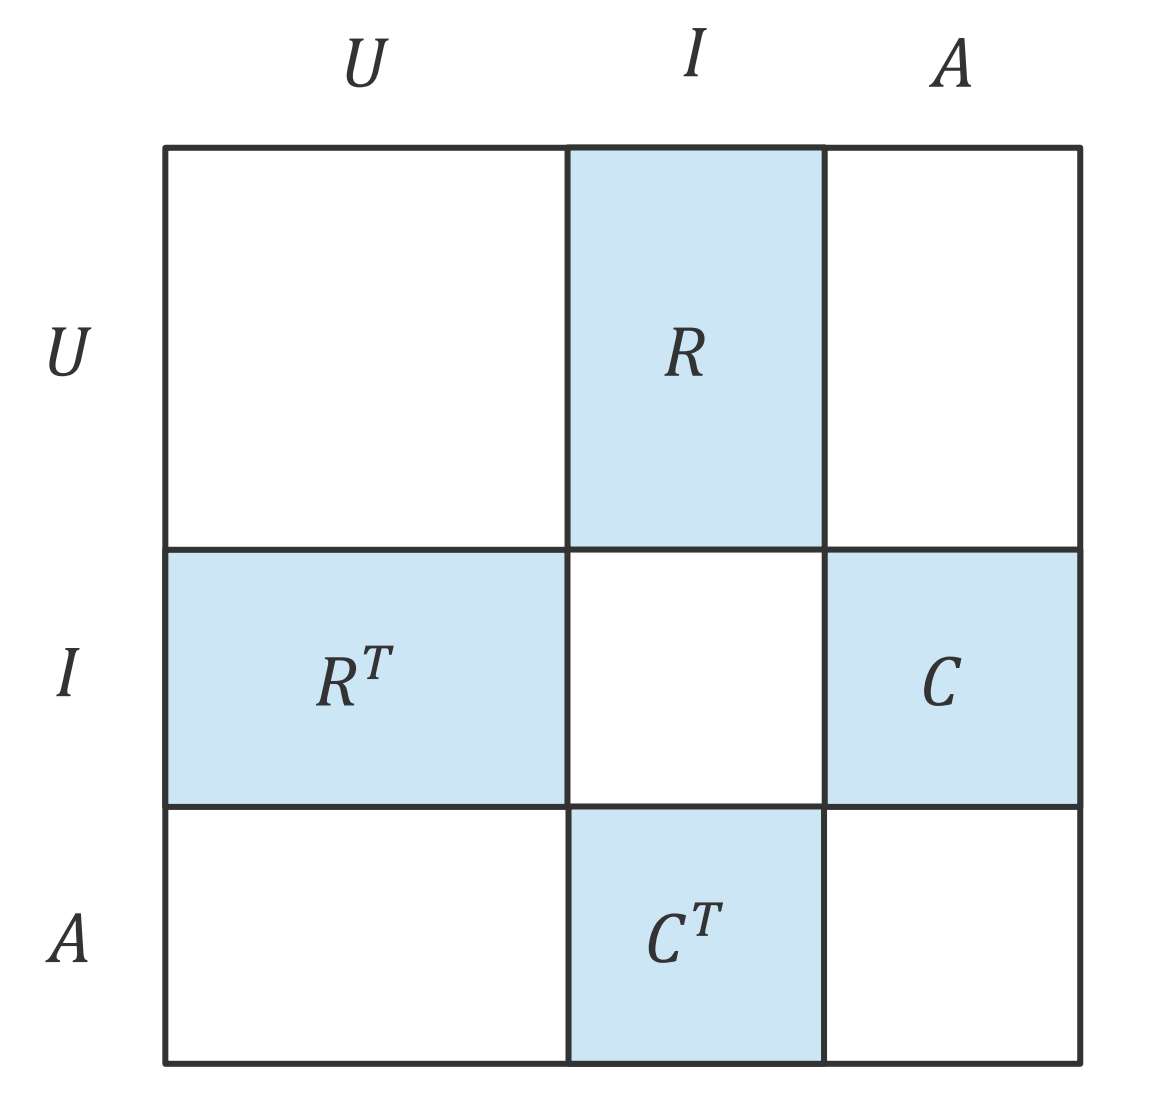

Notice how attributes are only connected to items. A case for user-related attributes can also be explored, but it is out of the scope of this practice session.

#### How do Random Walks change?

Now, we are not only interested in the $U \rightarrow I \rightarrow U \rightarrow I$ meta-path, as we can structure random walks that also follow the $U \rightarrow I \rightarrow A \rightarrow I$ meta-path. We will need to handle this case as well.

In [ ]:
ICM_genres = data_loaded.get_loaded_ICM_dict()["ICM_genres"]

In [ ]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Evaluation.Evaluator import EvaluatorHoldout

icm_weight = 0.5 # <- tunable hyperparameter

# Train graph-based recommender
# U -> I -> [U -> I] <-- normal RP3beta
u_i_recommender = RP3betaRecommender(URM_train_val)
u_i_recommender.fit(alpha=0.5, beta=0.3, implicit=True)

# U -> I -> [A -> I] <-- tag-based RP3beta
a_i_recommender = RP3betaRecommender(ICM_genres.T)
a_i_recommender.fit(alpha=0.5, beta=0.3)

custom_similarity = u_i_recommender.W_sparse + icm_weight * a_i_recommender.W_sparse # <- additionally, you could try normalizations

# Hybrid similarity recommender
recommender = ItemKNNCustomSimilarityRecommender(URM_train_val)
recommender.fit(custom_similarity)

evaluator_test = EvaluatorHoldout(URM_test, [10])

result_df_hybrid, _ = evaluator_test.evaluateRecommender(recommender)
result_df_hybrid

RP3betaRecommender: URM Detected 31 ( 0.3%) items with no interactions.
RP3betaRecommender: Similarity column 10681 (100.0%), 1696.29 column/sec. Elapsed time 6.30 sec
RP3betaRecommender: Similarity column 10681 (100.0%), 7347.02 column/sec. Elapsed time 1.45 sec
ItemKNNCustomSimilarityRecommender: URM Detected 31 ( 0.3%) items with no interactions.
EvaluatorHoldout: Ignoring 81 ( 0.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 69797 (100.0%) in 15.19 sec. Users per second: 4594


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.302258,0.345797,0.191316,0.217371,0.24167,0.603101,0.292025,0.234318,0.838847,1.096253,...,0.998841,0.837875,0.998841,0.01167,7.081081,0.986881,0.059933,0.625261,2.079951,0.070043
